# Teach Your Laptop to Trade Stock Options.
# Notebook 3: Train Machine Learners.
What could possibly go wrong?

07/30/2020

## Purpose of this Notebook - Train Learners to trade stock options.
This notebook is the third in a series of notebooks that demonstrate how to train a Machine learner to trade stock options, successfully, we hope. This notebook shows how to train several Learners and compare them to choose the best one for your specific project. This notebook uses a data set of stock option trades for ExxonMobil (XOM) from 2017-2018 to illustrate many aspects of Machine Learning with the python SKLearn library. All the trades are short covered calls. 

What You Need: Basic knowledge of Python, pandas, numpy, dataframes, and statistics. 

What You Don't Need: Knowledge of stock options, scipy, sklearn, or Machine Learning. This project is self-contained and you will learn as you go.

You will Learn:

- How to display features for visual evaluation of feature quality.
- How to set up several Learners for comparison on your feature set.
- How to capture performance data and execution time data for comparison.
- How to display comparison data for visual inspection.


## 1. Explore the Feature Set.

Load the csv file training_features.csv into a dataframe. 

Although you do not need any knowledge of stock options, or even finance, to use this notebook, a little information may make it more interesting.

Column Name Abbreviations
- STO - 'Sell to Open.' A trader may sell or buy a put or call contract to open a trade.
- ARR - 'Annual Return Rate.' The equivalent rate of return on the trade, if it expires, on an annual basis.
- strike_delta% - The difference between the stock price and the option strike price (the delta) as a % of stock price.
- days long - The number of days from the trade date to the expiry date.
- Profit$ - the $ profit/loss for the specific trade.
- Profit% - the profit/loss for the trade measured as a percent of the stock price at the time the trade was opened.

Evaluation Questions: 
- Do think these features are sufficient to predict the profitability of this type of option trade? Why, why not?
- What other features would you add to this feature set?
- How will you evaluate feature quality and contribbution to the results?

Code Questions:
- How many features are in this feature set?
- What is the data type of each feature?
- What are the statistics of each feature? Get the min, max, mean, and standard deviation of each. Use built-in functions.


In [1]:
import pandas as pd
import numpy as np
training_features = pd.DataFrame()
training_features = pd.read_csv('training_features_wlabel.csv', index_col = False)
print(training_features.head(5))
print(training_features.columns.to_list())

   Unnamed: 0  stock_price_at_STO_offer  STO_strike  STO_days_long  \
0           0                     81.82        80.0           11.0   
1           1                     81.81        80.0           11.0   
2           2                     81.82        80.5           11.0   
3           3                     81.81        80.5           11.0   
4           4                     82.10        80.5           11.0   

   STO_offer_ARR  stock_price_at_open  STO_ask_fee%  STO_offer_strike_delta%  \
0       0.786760                82.10      0.023711                -0.022244   
1       0.784828                82.10      0.023652                -0.022124   
2       0.618458                82.10      0.018638                -0.016133   
3       0.608394                82.10      0.018335                -0.016013   
4       0.701224                82.14      0.021133                -0.019488   

   Closed_xtn_Profit$  Closed_xtn_Profit%  ...        MFI     MACD  \
0              -610.0       

## 2. Visualize the Feature Set

With Matplotlib, compare the features when grouped by proitable trades ('winners' with label = 1) vs. unprofitable trades ('losers' with label = 0). 

(5577, 29)
setting up bins.


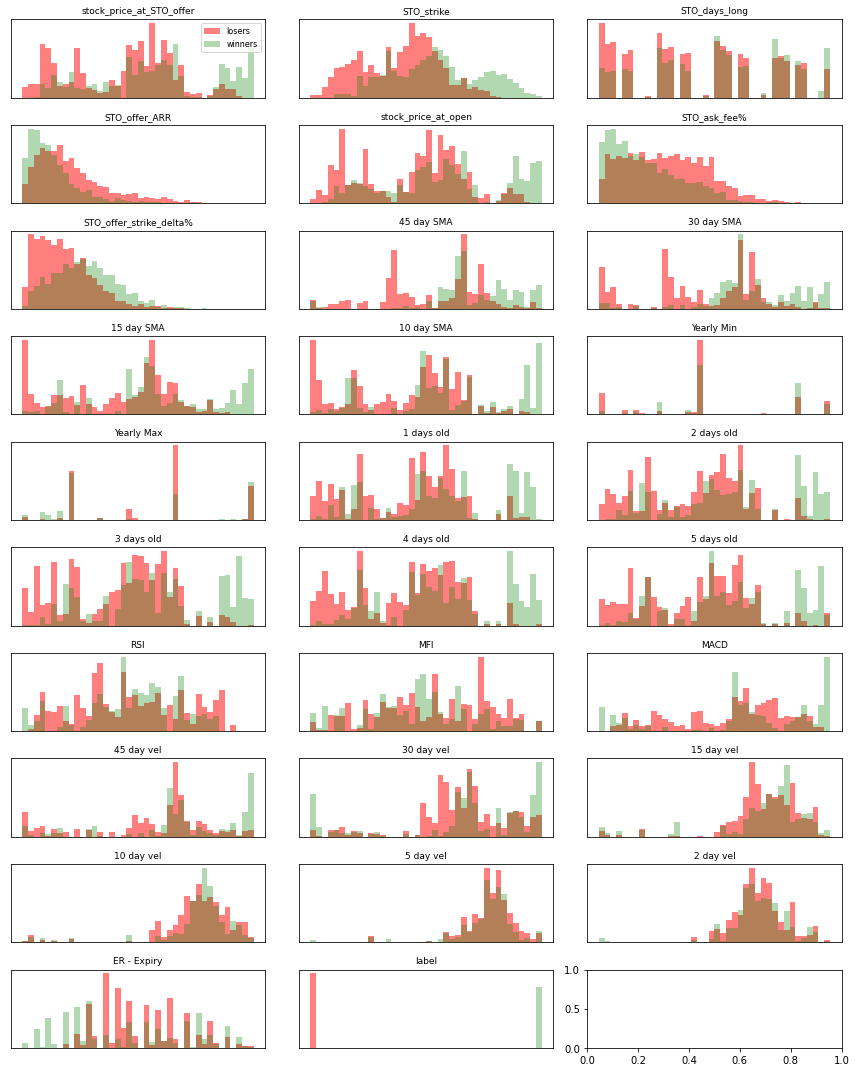

In [2]:
import matplotlib
import matplotlib.pyplot as plt

opt_sample = pd.read_csv('opt_sample.csv', index_col = 0)
print(opt_sample.shape)
#print(opt_sample.head(5))
fig,axes =plt.subplots(10,3, figsize=(12, 15)) # 3 columns each containing 9 figures, total 27 features
winners = opt_sample[opt_sample['label']==1]    # define winners
losers  = opt_sample[opt_sample['label']==0]    # define losers

winners = winners.to_numpy()
losers  = losers.to_numpy()
opt_np = opt_sample.to_numpy()

ax=axes.ravel()# flat axes with numpy ravel

print('setting up bins.') 
for i in range(len(opt_sample.columns.values)):
  _,bins=np.histogram(opt_np[:,i],bins=40)
  
  ax[i].hist(losers[:,i],bins=bins,color='r',alpha=.5)# red color for malignant class
  ax[i].hist(winners[:,i],bins=bins,color='g',alpha=0.3)# alpha is           for transparency in the overlapped region
  ax[i].set_title(opt_sample.columns.values[i],fontsize=9)
  ax[i].axes.get_xaxis().set_visible(False) # the x-axis co-ordinates are not so useful, as we just want to look how well separated the histograms are
  ax[i].set_yticks(())
ax[0].legend(['losers','winners'],loc='best',fontsize=8)
plt.tight_layout()# let's make good plots
plt.show()


Each chart above shows a collection of green bars and red bars for a single feature. 

Evaluation Questions:
 - What is the meaning of the green bars and red bars?
 - By looking at the charts, can you identify which features contain more information to train the Learners? How? Why?
 - Which chart shows perfect separation between the red and green bars. Why?
 - Can we use this feature to train the Learners? Why, why not?
 - In your opinion, can we train the Learners effectively with this set of features? Why, why not? 
 
 Code Questions:
 - Develop a single metric that defines the relationship between red and greed data points for each feature.
 - Compare your metric to the charts. Does your metric provide additional insight? Why, why not.
 - Calculate the correlation matrix of all the features. Hint, this is a single line of code with a dataframe.
 - Rank the features with the highest correlation, then plot the correlation as a series of charts. Any benefit?
 - Rank the correlation of each feature with the label, then plot. Any additional benefit?
 
The correlation analysis is one method to perform feature reduction or elimination, which is a key component in feature development. The next notebook in this series shows several techniques to do feature elimination.

## 3. Write the Function to Test Different Classifiers.

Review the function to train, test, and measure different Learners. Review the online documentation for the SKLearn library and read about each of these Learners.

Evaluation Questions:
 - What is a regressor? a classifier? Which should we use for this project as set up? Why?
 - How would we change the setup to use the other type? Which would be better? Why?
 - Describe each Learner in your own words. Which ones do you think will work best for this project? Why?
 
Code Questions:
 - When you execute the code block below, what output do you expect to see? Why? This is a trick question.
 - How will you add another Learner to the evaluation set?

In [3]:
# Import ML Libraries from SKLearn.

from sklearn import svm
from sklearn import metrics
from sklearn.decomposition     import PCA
from sklearn.preprocessing     import StandardScaler
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.neural_network    import MLPClassifier
from sklearn.ensemble          import RandomForestClassifier, AdaBoostClassifier
from sklearn.datasets          import make_classification
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.neural_network    import MLPClassifier
from sklearn.naive_bayes       import GaussianNB 
from sklearn.feature_selection import SelectKBest
import xgboost
from xgboost                   import XGBClassifier
import catboost
from catboost                  import CatBoostClassifier
from sklearn.feature_selection import chi2

import time
import random

def RunLearners(Xr_train, Xr_test, yr_train, yr_test, all_run_stats, run_ID):
   print() 
   print('Please be patient. Some of these Learners are pretty slow learners.')
   print('If you get impatient, put in a print statement to show progress, or just use one already in place.')
   print()
    
   this_run_stats = pd.DataFrame()
   
   learners = {'RandomForest_d6'  : RandomForestClassifier(max_depth=3, random_state=97),
               'RandomForest_d12' : RandomForestClassifier(max_depth=12, random_state=97),
               #'KNNeighbors_2'    : KNeighborsClassifier(n_neighbors=3),
               'KNNeighbors_8'    : KNeighborsClassifier(n_neighbors=8),
               'MLPerceptron'     : MLPClassifier(alpha=1, max_iter=1000),
               'SVC linear'       : svm.SVC(kernel = 'linear'),
               #'SVC poly'         : svm.SVC(kernel = 'poly'),
               #'GaussianNB'       : GaussianNB(),
               'AdaBoost'         : AdaBoostClassifier(),
               'XGBoost'          : XGBClassifier(),
               'CatBoost'         : CatBoostClassifier()
               #'SVC sigmoid'      : svm.SVC(kernel = 'sigmoid')
               }

   learner_types = learners.keys()
   for learner in learner_types:
      clf = learners[learner]
      start_time = time.time()  
      clf.fit(Xr_train, yr_train)
      end_time = time.time()
      train_time = end_time - start_time
      start_time = time.time()  
      yr_pred = clf.predict(X_test)
      end_time = time.time()
      predict_time = end_time - start_time
        
      #print()
      #print('for learner ', learner)
      #print(learner, ' accuracy      = ', metrics.accuracy_score(yr_test, yr_pred))
      #print(learner, ' avg. precison = ', metrics.average_precision_score(yr_test, yr_pred))

      this_run_stats.loc[learner, 'Accuracy']     = metrics.accuracy_score(yr_test, yr_pred)
      this_run_stats.loc[learner, 'Precision']    = metrics.average_precision_score(yr_test, yr_pred)
      this_run_stats.loc[learner, 'Train time']   = train_time
      this_run_stats.loc[learner, 'Predict time'] = predict_time

   this_run_stats['run_ID'] = run_ID
   all_run_stats = all_run_stats.append(this_run_stats)
   return all_run_stats
   print('all_run_stats = ')
   print(all_run_stats) 

print()
print('No output yet. Call this function with a set of train and test features.')
print('Then run the code block below to prepare a set of train and test data, then call the function RunLearners')
print('to execute each of the Learners and collect performance metrics.')



No output yet. Call this function with a set of train and test features.
Then run the code block below to prepare a set of train and test data, then call the function RunLearners
to execute each of the Learners and collect performance metrics.


## 4. Investigate the train and test data sets.
Run the code block below, then consider these questions.

Evaluation Questions:
- Explain the differences between X_train, y_train, X_test, and y_test. 
- What are the dimensions of each?
- What is the purpose of each?
- What is the difference between a numpy array and a dataframe? Which works with a Learner?
- How does the code modify X_train? Why?

In [4]:
# Prepare the test and train data sets.

X_train = pd.DataFrame()
y_train = pd.DataFrame()
X_test  = pd.DataFrame()
y_test  = pd.DataFrame()

learner_stats = pd.DataFrame()

X_train  = pd.read_csv('opt_sample.csv', index_col = 0)

#print(X_train.head(10))
y_train = X_train[['label']].to_numpy()
y_train = y_train.ravel()
print('y_train shape = ', y_train.shape)
X_train.drop(labels = 'label', axis = 'columns', inplace = True)
print('X_train shape = ', X_train.shape)

X_test = pd.read_csv('opt_test.csv', index_col = 0)
y_test = X_test[['label']].to_numpy()
X_test.drop(labels = 'label', axis = 'columns', inplace = True)

y_train = np.ravel(y_train)
y_test  = np.ravel(y_test)
#print('y_train = ', y_train)
#print('y_test = ', y_test)

run_ID = 'Initial'
learner_stats = RunLearners(X_train, X_test, y_train, y_test, learner_stats, run_ID)
print(learner_stats)
learner_stats.to_csv('learner_stats.csv')

y_train shape =  (5577,)
X_train shape =  (5577, 28)

Please be patient. Some of these Learners are pretty slow learners.
If you get impatient, put in a print statement to show progress, or just use one already in place.

Learning rate set to 0.021461
0:	learn: 0.6723207	total: 190ms	remaining: 3m 9s
1:	learn: 0.6533127	total: 205ms	remaining: 1m 42s
2:	learn: 0.6344295	total: 219ms	remaining: 1m 12s
3:	learn: 0.6148469	total: 229ms	remaining: 57.1s
4:	learn: 0.6015248	total: 241ms	remaining: 47.9s
5:	learn: 0.5892385	total: 252ms	remaining: 41.7s
6:	learn: 0.5715064	total: 262ms	remaining: 37.2s
7:	learn: 0.5525373	total: 274ms	remaining: 33.9s
8:	learn: 0.5372496	total: 284ms	remaining: 31.3s
9:	learn: 0.5250370	total: 295ms	remaining: 29.2s
10:	learn: 0.5116350	total: 306ms	remaining: 27.5s
11:	learn: 0.4990179	total: 316ms	remaining: 26.1s
12:	learn: 0.4879750	total: 327ms	remaining: 24.8s
13:	learn: 0.4782065	total: 338ms	remaining: 23.8s
14:	learn: 0.4716090	total: 349ms	remainin

162:	learn: 0.1575028	total: 2.16s	remaining: 11.1s
163:	learn: 0.1568824	total: 2.18s	remaining: 11.1s
164:	learn: 0.1563973	total: 2.19s	remaining: 11.1s
165:	learn: 0.1557664	total: 2.21s	remaining: 11.1s
166:	learn: 0.1548918	total: 2.23s	remaining: 11.1s
167:	learn: 0.1545327	total: 2.24s	remaining: 11.1s
168:	learn: 0.1538070	total: 2.26s	remaining: 11.1s
169:	learn: 0.1531148	total: 2.27s	remaining: 11.1s
170:	learn: 0.1525824	total: 2.28s	remaining: 11.1s
171:	learn: 0.1522713	total: 2.3s	remaining: 11.1s
172:	learn: 0.1514198	total: 2.31s	remaining: 11.1s
173:	learn: 0.1500832	total: 2.33s	remaining: 11.1s
174:	learn: 0.1493595	total: 2.35s	remaining: 11.1s
175:	learn: 0.1487271	total: 2.37s	remaining: 11.1s
176:	learn: 0.1482518	total: 2.38s	remaining: 11.1s
177:	learn: 0.1473202	total: 2.39s	remaining: 11.1s
178:	learn: 0.1470832	total: 2.41s	remaining: 11s
179:	learn: 0.1463411	total: 2.42s	remaining: 11s
180:	learn: 0.1456327	total: 2.43s	remaining: 11s
181:	learn: 0.14529

322:	learn: 0.0931008	total: 4.33s	remaining: 9.08s
323:	learn: 0.0928326	total: 4.34s	remaining: 9.07s
324:	learn: 0.0921971	total: 4.36s	remaining: 9.06s
325:	learn: 0.0919810	total: 4.38s	remaining: 9.06s
326:	learn: 0.0916568	total: 4.4s	remaining: 9.06s
327:	learn: 0.0913341	total: 4.42s	remaining: 9.06s
328:	learn: 0.0910672	total: 4.44s	remaining: 9.05s
329:	learn: 0.0908933	total: 4.45s	remaining: 9.04s
330:	learn: 0.0906242	total: 4.47s	remaining: 9.03s
331:	learn: 0.0905296	total: 4.48s	remaining: 9.02s
332:	learn: 0.0902230	total: 4.5s	remaining: 9.01s
333:	learn: 0.0899118	total: 4.52s	remaining: 9.01s
334:	learn: 0.0894505	total: 4.53s	remaining: 9s
335:	learn: 0.0893340	total: 4.56s	remaining: 9.01s
336:	learn: 0.0892258	total: 4.57s	remaining: 9s
337:	learn: 0.0890207	total: 4.59s	remaining: 8.99s
338:	learn: 0.0888464	total: 4.61s	remaining: 8.98s
339:	learn: 0.0885309	total: 4.63s	remaining: 8.98s
340:	learn: 0.0884268	total: 4.64s	remaining: 8.97s
341:	learn: 0.088115

483:	learn: 0.0608084	total: 6.68s	remaining: 7.12s
484:	learn: 0.0607871	total: 6.7s	remaining: 7.11s
485:	learn: 0.0606869	total: 6.71s	remaining: 7.1s
486:	learn: 0.0606173	total: 6.73s	remaining: 7.09s
487:	learn: 0.0604853	total: 6.75s	remaining: 7.08s
488:	learn: 0.0604496	total: 6.76s	remaining: 7.07s
489:	learn: 0.0604112	total: 6.78s	remaining: 7.06s
490:	learn: 0.0603865	total: 6.8s	remaining: 7.05s
491:	learn: 0.0602325	total: 6.81s	remaining: 7.04s
492:	learn: 0.0601494	total: 6.83s	remaining: 7.02s
493:	learn: 0.0598112	total: 6.84s	remaining: 7.01s
494:	learn: 0.0597189	total: 6.87s	remaining: 7s
495:	learn: 0.0596091	total: 6.89s	remaining: 7s
496:	learn: 0.0594373	total: 6.9s	remaining: 6.99s
497:	learn: 0.0591715	total: 6.92s	remaining: 6.97s
498:	learn: 0.0589217	total: 6.93s	remaining: 6.96s
499:	learn: 0.0587830	total: 6.94s	remaining: 6.94s
500:	learn: 0.0587015	total: 6.95s	remaining: 6.92s
501:	learn: 0.0585971	total: 6.96s	remaining: 6.91s
502:	learn: 0.0584548	

642:	learn: 0.0435683	total: 8.81s	remaining: 4.89s
643:	learn: 0.0434256	total: 8.83s	remaining: 4.88s
644:	learn: 0.0433199	total: 8.84s	remaining: 4.87s
645:	learn: 0.0432127	total: 8.85s	remaining: 4.85s
646:	learn: 0.0431232	total: 8.87s	remaining: 4.84s
647:	learn: 0.0430386	total: 8.88s	remaining: 4.82s
648:	learn: 0.0430246	total: 8.89s	remaining: 4.81s
649:	learn: 0.0429118	total: 8.9s	remaining: 4.79s
650:	learn: 0.0428620	total: 8.91s	remaining: 4.78s
651:	learn: 0.0427698	total: 8.92s	remaining: 4.76s
652:	learn: 0.0427064	total: 8.93s	remaining: 4.75s
653:	learn: 0.0426239	total: 8.95s	remaining: 4.73s
654:	learn: 0.0425331	total: 8.96s	remaining: 4.72s
655:	learn: 0.0424168	total: 8.97s	remaining: 4.7s
656:	learn: 0.0423455	total: 8.98s	remaining: 4.69s
657:	learn: 0.0422870	total: 8.99s	remaining: 4.67s
658:	learn: 0.0422206	total: 9.01s	remaining: 4.66s
659:	learn: 0.0421026	total: 9.02s	remaining: 4.64s
660:	learn: 0.0420443	total: 9.03s	remaining: 4.63s
661:	learn: 0.

810:	learn: 0.0328219	total: 10.8s	remaining: 2.51s
811:	learn: 0.0327979	total: 10.8s	remaining: 2.5s
812:	learn: 0.0327572	total: 10.8s	remaining: 2.48s
813:	learn: 0.0326976	total: 10.8s	remaining: 2.47s
814:	learn: 0.0325399	total: 10.8s	remaining: 2.46s
815:	learn: 0.0325221	total: 10.8s	remaining: 2.44s
816:	learn: 0.0324819	total: 10.8s	remaining: 2.43s
817:	learn: 0.0323331	total: 10.9s	remaining: 2.42s
818:	learn: 0.0322970	total: 10.9s	remaining: 2.4s
819:	learn: 0.0322218	total: 10.9s	remaining: 2.39s
820:	learn: 0.0321444	total: 10.9s	remaining: 2.37s
821:	learn: 0.0321097	total: 10.9s	remaining: 2.36s
822:	learn: 0.0320720	total: 10.9s	remaining: 2.35s
823:	learn: 0.0320199	total: 10.9s	remaining: 2.33s
824:	learn: 0.0319952	total: 10.9s	remaining: 2.32s
825:	learn: 0.0319587	total: 10.9s	remaining: 2.31s
826:	learn: 0.0319282	total: 11s	remaining: 2.29s
827:	learn: 0.0319056	total: 11s	remaining: 2.28s
828:	learn: 0.0317666	total: 11s	remaining: 2.27s
829:	learn: 0.031732

983:	learn: 0.0247286	total: 12.7s	remaining: 207ms
984:	learn: 0.0246920	total: 12.7s	remaining: 194ms
985:	learn: 0.0246507	total: 12.8s	remaining: 181ms
986:	learn: 0.0246143	total: 12.8s	remaining: 168ms
987:	learn: 0.0245415	total: 12.8s	remaining: 155ms
988:	learn: 0.0244719	total: 12.8s	remaining: 142ms
989:	learn: 0.0244251	total: 12.8s	remaining: 129ms
990:	learn: 0.0244170	total: 12.8s	remaining: 116ms
991:	learn: 0.0243745	total: 12.8s	remaining: 103ms
992:	learn: 0.0243463	total: 12.8s	remaining: 90.5ms
993:	learn: 0.0242433	total: 12.8s	remaining: 77.5ms
994:	learn: 0.0242249	total: 12.9s	remaining: 64.6ms
995:	learn: 0.0241845	total: 12.9s	remaining: 51.7ms
996:	learn: 0.0241498	total: 12.9s	remaining: 38.7ms
997:	learn: 0.0241391	total: 12.9s	remaining: 25.8ms
998:	learn: 0.0241061	total: 12.9s	remaining: 12.9ms
999:	learn: 0.0240973	total: 12.9s	remaining: 0us
                  Accuracy  Precision  Train time  Predict time   run_ID
RandomForest_d6   0.837389   0.765693 

## 5. Plot and Compare Performance of the Learners.

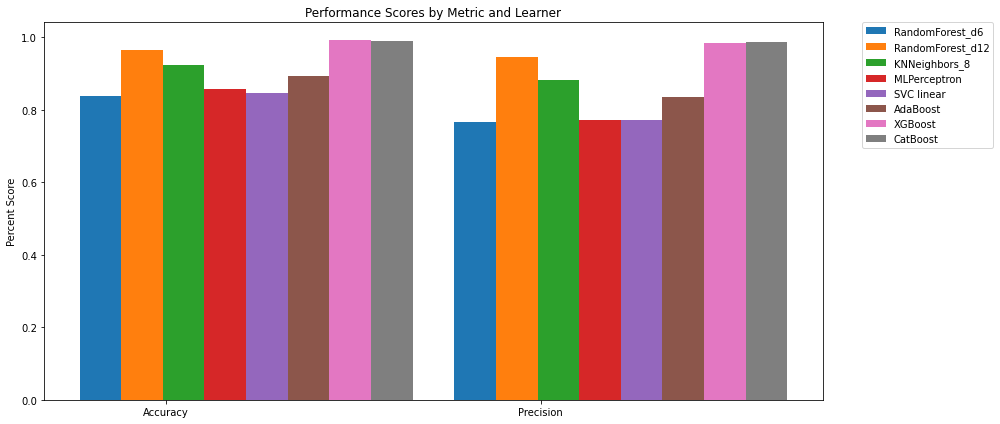

In [5]:
#Print and compare Learner performance in grouped bar chart format

def PlotGroupedBarChart(group_list, agent_list, scores):
   
    agent_scores = []
    rects = []
    labels = group_list # bar chart groups
    num_labels = len(labels) + 1

    num_agents = len(agent_list) + 1
    num_bars = num_labels * num_agents
    bar_width = 3 / num_bars
    width = .35
    
    plt.rcParams['figure.figsize'] = [14,6]

    x = np.arange(len(labels))  # the label locations

    fig, ax = plt.subplots()
    num_bars = len(agent_list)
    bar_posn = 0
    for agent in agent_list:
        agent_scores = [scores.loc[agent, labels[0]], scores.loc[agent, labels[1]]]
        rects.append(ax.bar(x - width/2  + bar_width * bar_posn, agent_scores, bar_width, label=agent))
        bar_posn += 1
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Percent Score')
    ax.set_title('Performance Scores by Metric and Learner')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    #plt.legend(loc = 'lower right')
    fig.tight_layout()
    plt.show()
    
#Run the plot function to compare performance of the Learners.

metrics = ['Accuracy', 'Precision']
agents  = learner_stats.index.tolist()

PlotGroupedBarChart(metrics, agents, learner_stats)

Refer to the performance chart above to answer these questions:

Evaluation Questions. You may need to modify function RunLearners and run it a few times with different learners to answer these evaluation questions. Note some other learners are already set up, just commented out.
- What is the difference between accuracy and precision? What other performance metrics might be useful here?
- Which Learner performed best on both metrics?
- Comparing RandomForest Learners, what do the suffixes mean?
- Which RandomForest did better? Why?
- What problems would you expect to see if we continued increasing the d parameter?
- How can you find the best value for the d parameter?
- Do the same comparison and analysis for the KNNeighbors numeric suffix.
- Why did CatBoost, XGBoost, RandomForest and KNNeighbors perform so much better than the other Learners?
- What does AdaBoost boost? XGBoost? CatBoost? What is boosting, anyway?
- How could you improve AdaBoost? XGBoost? CatBoost?
- Based on the performance parameters, would you consider this learning challenge to be linear, nonlinear, or other? Why, why not?

Code Questions:
- Change the parameters KNNeighbor and RandomForest. Explain the results.
- Change the parameters for AdaBoost and XGBoost. Explain the results. 
- Test another type of classifier. Predict the results for that classifier, then run it and compare to your prediction. 
- Change the parameters for SVC and MLP. Can you improve their performance with different parameters?
- Change the y axis of the plot to expand the performance differences of the Learners. Is that better, or just deceptive?


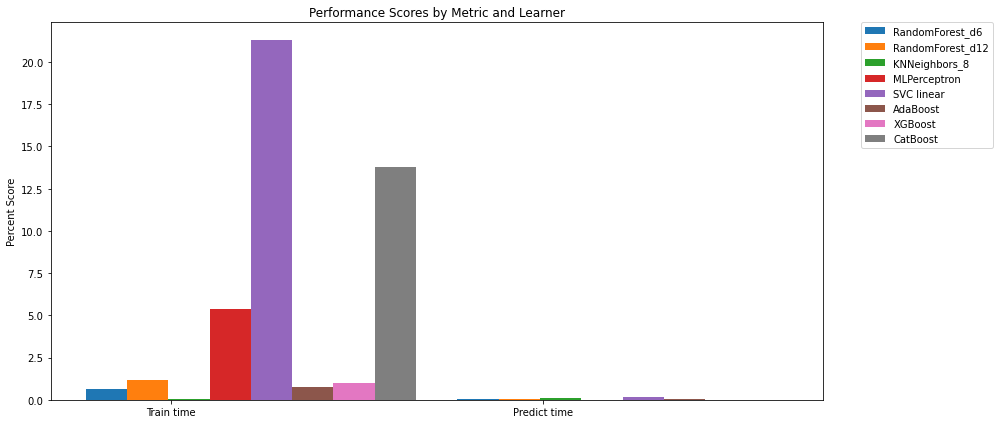

In [6]:
#Run the plot function to compare execution time of the Learners.

#Plot execution time metrics
exec_times = ['Train time', 'Predict time']

PlotGroupedBarChart(exec_times, agents, learner_stats)



Refer to the chart above to answer these questions about execution times.

Evaluation Questions. You may need to modify function RunLearners and run it a few times with different learners selected to answer these Evaluation Questions. 
- Why does SVC Linear take so long to train?
- Why does KNNeighbors train so quickly?
- Why does RandomForest train time increase as the d parameter increases?
- Why is prediction time so much faster than train time for all Learners except KN Neighbors?
- Why is KN Neighbors slower on prediction time?
- Which is more important - train time or prediction time? Why? What circumstances?
- What circumstances or requirements might change the relative importance of train time vs. prediciton time?
- Given the execution times above, can you predict how train time will change as the training data set increases? Why?

Code Questions:
- In the chart, execution times are not well displayed. Change the chart to improve their display.
- Which data sets are used for training?
- Make those data sets 50% smaller, then 90% smaller, then rerun the Learners and plot the results.
- How do the results change with the smaller data sets? Why?

## Congratulations, You trained and compared several Learners.

Congratulations! You just trained several Learners to pick winning stock option trades. Now, you are almost ready to make a fortune in the stock market. But, first... consider these questions:

- How can you improve the feature set? 
- Which Learner(s) would you choose? Why?
- How can you gain more confidence in your trader?
- What is your goal? Single profitable trades, or a portfolio of trades? What's the difference?

Tune into the next exciting notebook to explore questions of maximizing portfolio results for options trading. 

Wishing you only profitable trades and good learning,

Richard Barrett

richard at rbshomes dot com.

P.S. I want to hear about your adventures in Machine Learning, your quesitons and comments about stock option trading, and especially your specific applications for machine learning. Just shoot me an email.
